<a href="https://colab.research.google.com/github/rajeshbabu1990/Data_science/blob/main/Linear_Regression_KNN_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Library

In [11]:
#Import the essential libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


-------

#Data Loading

In [12]:
file_path='/content/drive/My Drive/raw_house_data.csv'
data=pd.read_csv(file_path)
data.shape

(5000, 16)



#Data preprocessing

In [13]:
# drop the rows where 3 features are missing
final_val=data.dropna(thresh=len(data.columns) - 3)
final_val.shape

(4996, 16)

In [14]:
final_val = final_val.dropna(subset=['sqrt_ft'])

In [ ]:
final_val.isnull().sum()

In [16]:
final_val.fillna(value=0,inplace=True)

## Number of rooms calculation

In [17]:
# Number of rooms calculated in new column Number of Rooms
final_val.loc[:,"Number of Rooms"]=final_val['bedrooms']+final_val['bathrooms']
final_val.loc[:,"Number of Rooms"]



,Number of Rooms
0,23.0
1,4.0
3,12.0
4,10.0
5,7.0
...,...
4995,8.0
4996,7.0
4997,5.0
4998,8.0


In [18]:
final_val["House_Age"] = pd.Timestamp.now().year - final_val["year_built"]
final_val = final_val.drop(['year_built'], axis=1)

In [19]:
final_val.shape


(4944, 17)

In [20]:
final_val.head()

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,Number of Rooms,House_Age
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,13,10.0,10500.0,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6.0,"Mexican Tile, Wood",0,23.0,84
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,2,2.0,7300.0,0.0,"Dishwasher, Garbage Disposal",5.0,"Natural Stone, Other",0,4.0,28
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,7,5.0,9019.0,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4.0,"Ceramic Tile, Laminate, Wood",0,12.0,95
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,4,6.0,6396.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5.0,"Carpet, Concrete",55,10.0,30
5,21528016,3250000.0,85718,-110.910593,32.339090,1.67,27802.84,3,4.0,6842.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5.0,"Natural Stone, Wood, Other",422,7.0,26


## Price per SQFT calculation


In [21]:
# SQFT calculated in new column

final_val.loc[:,'Price per Sqft']=final_val['sold_price']/final_val['sqrt_ft']
final_val['Price per Sqft']

,Price per Sqft
0,504.761905
1,575.342466
3,498.946668
4,533.372420
5,475.007308
...,...
4995,137.461816
4996,237.273512
4997,268.058691
4998,147.690655


In [22]:
# # Grouped by zipcode to valued the median for missing Price per Sqft & HOA

# final_val.loc[:, 'Price per Sqft'] = final_val.groupby('zipcode')['Price per Sqft'].transform(lambda x: x.fillna(x.median()))
# final_val.loc[:,'HOA'] = pd.to_numeric(final_val['HOA'], errors='coerce')
# final_val.loc[:, 'HOA'] = final_val.groupby('zipcode')['HOA'].transform(lambda x: x.fillna(x.median()))
# final_val.loc[:, 'HOA'] = final_val.groupby('zipcode')['HOA'].transform(lambda x: x.fillna(x.median()))

# final_val['HOA'].head()

final_val.isnull().sum()

,0
MLS,0
sold_price,0
zipcode,0
longitude,0
latitude,0
lot_acres,0
taxes,0
bedrooms,0
bathrooms,0
sqrt_ft,0


# Preparing variable for the KNN classifier & regressor

## Created BIN column

In [23]:
# Created Bin for Price Per Sqft
final_val.loc[:,'Price_Bin'] = pd.qcut(final_val['Price per Sqft'], q=20, labels=False)

final_val.columns

Index(['MLS', 'sold_price', 'zipcode', 'longitude', 'latitude', 'lot_acres',
       'taxes', 'bedrooms', 'bathrooms', 'sqrt_ft', 'garage',
       'kitchen_features', 'fireplaces', 'floor_covering', 'HOA',
       'Number of Rooms', 'House_Age', 'Price per Sqft', 'Price_Bin'],
      dtype='object')

In [24]:
print(final_val[['Price per Sqft', 'Price_Bin']])

      Price per Sqft  Price_Bin
0         504.761905         19
1         575.342466         19
3         498.946668         19
4         533.372420         19
5         475.007308         19
...              ...        ...
4995      137.461816          0
4996      237.273512         15
4997      268.058691         17
4998      147.690655          1
4999      104.239055          0

[4944 rows x 2 columns]


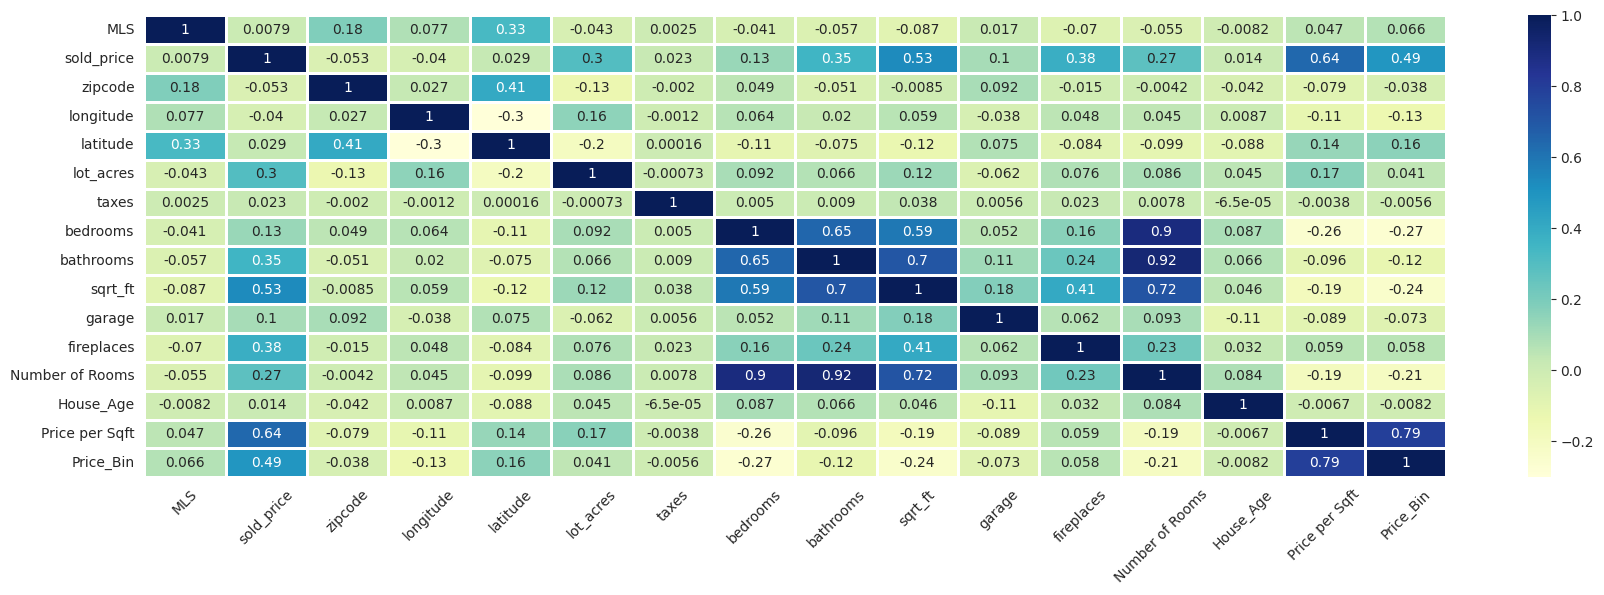

In [25]:
numeric_final_val = final_val.select_dtypes(include=[np.number])

fig = plt.figure(figsize=(21, 6))
sns.set_style('darkgrid', rc={'axes.facecolor': '#eaf'})
sns.set_palette('viridis', 12)
sns.heatmap(numeric_final_val.corr(), annot=True, cmap="YlGnBu", linewidths=1)
plt.xticks(rotation=45)
plt.show()

## Geo Partial value assigned to the X Variable and y as Prices per sqft

---



In [29]:
X=final_val.loc[:,['latitude','longitude']].to_numpy()



In [30]:
y=final_val['Price_Bin'].to_numpy().astype('int64')

In [31]:
class KNNClassifier():

  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X, K, epsilon =1e-3):

    N=len(X)
    y_hat = np.zeros(N)

    for i in range(N):
      dist2 = np.sum((self.X-X[i])**2,axis=1)
      idxt =np.argsort(dist2)[:K]

      gamma_k = 1/(np.sqrt(dist2[idxt]+epsilon))

      y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k).argmax()


    return y_hat


In [32]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

In [33]:
KNNclassifiermodel = KNNClassifier()
KNNclassifiermodel.fit(X,y)


In [34]:
y_hat_knn_classifier=KNNclassifiermodel.predict(X,K=5)


In [35]:
accu_knn_classifier=accuracy(y,y_hat_knn_classifier)
print('Validation Accuracy for KNN:', round(accu_knn_classifier, 2))

Validation Accuracy for KNN: 0.69


##Creating Two Dataframes to sum Kitchen Features & Floor features

In [36]:
df2=final_val['kitchen_features'].str.split(',', expand=True).rename(columns = lambda x: "kitchen_f"+str(x+1));
df3=final_val['floor_covering'].str.split(',', expand=True).rename(columns = lambda x: "floor_c"+str(x+1))


In [ ]:
df2.fillna(0)


In [47]:
df2=df2.replace(regex={r'\D+': 1})  #instead of string values replacing as 1
df2=df2.fillna(0)
df2.head(5)



,kitchen_f1,kitchen_f2,kitchen_f3,kitchen_f4,kitchen_f5,kitchen_f6,kitchen_f7,kitchen_f8,kitchen_f9,kitchen_f10,kitchen_f11,kitchen_f12,kitchen_f13,kitchen_f14,kitchen_f15,Kitchen_Sum
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [48]:
df2['Kitchen_Sum']=df2.sum(axis=1)
print(df2.head(5))


   kitchen_f1  kitchen_f2  kitchen_f3  kitchen_f4  kitchen_f5  kitchen_f6  \
0         1.0         1.0         1.0         1.0         0.0         0.0   
1         1.0         1.0         0.0         0.0         0.0         0.0   
3         1.0         1.0         1.0         1.0         0.0         0.0   
4         1.0         1.0         1.0         1.0         1.0         0.0   
5         1.0         1.0         1.0         1.0         1.0         0.0   

   kitchen_f7  kitchen_f8  kitchen_f9  kitchen_f10  kitchen_f11  kitchen_f12  \
0         0.0         0.0         0.0          0.0          0.0          0.0   
1         0.0         0.0         0.0          0.0          0.0          0.0   
3         0.0         0.0         0.0          0.0          0.0          0.0   
4         0.0         0.0         0.0          0.0          0.0          0.0   
5         0.0         0.0         0.0          0.0          0.0          0.0   

   kitchen_f13  kitchen_f14  kitchen_f15  Kitchen_Sum  


In [49]:
df3.fillna(0)  #fill null value with zero
df3.head()


,floor_c1,floor_c2,floor_c3,floor_c4,floor_c5,floor_c6,Floor_Sum
0,1,1.0,0.0,0.0,0.0,0.0,2.0
1,1,1.0,0.0,0.0,0.0,0.0,2.0
3,1,1.0,1.0,0.0,0.0,0.0,3.0
4,1,1.0,0.0,0.0,0.0,0.0,2.0
5,1,1.0,1.0,0.0,0.0,0.0,3.0


In [50]:
df3=df3.replace(regex={r'\D+': 1});    #instead of string values, to write 1
df3=df3.fillna(0)
df3.head()

,floor_c1,floor_c2,floor_c3,floor_c4,floor_c5,floor_c6,Floor_Sum
0,1,1.0,0.0,0.0,0.0,0.0,2.0
1,1,1.0,0.0,0.0,0.0,0.0,2.0
3,1,1.0,1.0,0.0,0.0,0.0,3.0
4,1,1.0,0.0,0.0,0.0,0.0,2.0
5,1,1.0,1.0,0.0,0.0,0.0,3.0


In [51]:
df3['Floor_Sum']=df3.sum(axis=1)

df3.head(5)
df2.head(5)

,kitchen_f1,kitchen_f2,kitchen_f3,kitchen_f4,kitchen_f5,kitchen_f6,kitchen_f7,kitchen_f8,kitchen_f9,kitchen_f10,kitchen_f11,kitchen_f12,kitchen_f13,kitchen_f14,kitchen_f15,Kitchen_Sum
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
5,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


In [52]:
df_new= pd.concat([df2,df3], axis=1)
df_final_merge= pd.concat([final_val,df_new], axis=1)


In [54]:
df_final_merge.head(5)
df_final_merge.shape


(4944, 42)

In [55]:
train_ratio = 0.9

train_data_regres = df_final_merge.sample(frac=train_ratio, random_state=42)
test_data_regres = df_final_merge.drop(train_data_regres.index)

print(train_data_regres.shape)
print(test_data_regres.shape)

(4450, 42)
(494, 42)


In [56]:
class KNNRegressor():

 def fit(self,X,y):
  self.X=X
  self.y=y

 def predict(self,X,K,epsilon =1e-3):

  N=len(X)
  y_hat= np.zeros(N)

  for i in range(N):
    dist2 =np.sum((self.X-X[i])**2,axis=1)
    idxt = np.argsort(dist2)[:K]
    gamma_k = np.exp(-dist2[idxt])/(np.exp(-dist2[idxt]).sum()+epsilon)
    y_hat[i] = gamma_k.dot(self.y[idxt])

  return y_hat


In [103]:
#X_regres_train=train_data_regres[['latitude', 'longitude', 'Number of Rooms','Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age']].apply(lambda x: x.fillna(x.median())).to_numpy().astype('int64')

X_regres_train=train_data_regres[['Number of Rooms','Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age','Price_Bin']].to_numpy().astype('int64')

#X_regres_train=train_data_regres[['Number of Rooms','Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age','Price_Bin']].to_numpy().astype('int64')

In [104]:
#X_regres_test=test_data_regres[['latitude', 'longitude', 'Number of Rooms', 'Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age']].apply(lambda x: x.fillna(x.median())).to_numpy().astype('int64')

X_regres_test=test_data_regres[[ 'Number of Rooms', 'Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age','Price_Bin']].to_numpy().astype('int64')

#X_regres_test=test_data_regres[[ 'Number of Rooms', 'Price per Sqft','Floor_Sum','Kitchen_Sum','House_Age','Price_Bin']].to_numpy().astype('int64')

In [105]:
y_train=train_data_regres['sold_price'].to_numpy().astype('float')

In [106]:
y_test=test_data_regres['sold_price'].to_numpy().astype('float')

In [107]:
knnr = KNNRegressor()
knnr.fit(X_regres_train,y_train)

In [108]:
# X_regres_train = X_regres_train.reshape(-1, 1)
y_hat_knn_regr_train=knnr.predict(X_regres_train,1)

In [109]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [110]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [111]:
mae(y_train, y_hat_knn_regr_train),mse(y_train, y_hat_knn_regr_train)

(1310.2973979569838, 127459068.77489702)

In [112]:
y_hat_knn_regr_test=knnr.predict(X_regres_test, 1)

In [85]:
mae(y_test, y_hat_knn_regr_test),mse(y_train, y_hat_knn_regr_train)

(440425.05972719414, 127459068.77489702)

In [62]:
# y_hat_knn_regr_test = knnr.predict(X_regres_test,1)

In [113]:
def OLS(Y,Y_hat, N):
  return ((1/(2*N))*np.sum((Y-Y_hat)**2))

In [114]:
OLS(test_data_regres['Price_Bin'], y_hat_knn_regr_test,1500)

33957420860.7234

In [115]:
class MVLinearRegression():

    def fit(self, X, y, eta=1e-3, epochs=1e3, show_curve=False):
        epochs = int(epochs)


        X = (X - X.mean(axis=0)) / X.std(axis=0)

        X = X.astype(np.float64)
        y = y.astype(np.float64)
        N, D = X.shape
        Y = y

        #Begin SGD Optimization
        self.W = np.random.randn(D)
        self.J = np.zeros(epochs)
        max_clip = 1e100

        # Stochastic Gradient Descent Progression
        for epoch in range(epochs):
            Y_hat = self.predict(X)
            self.J[epoch] = OLS(Y, Y_hat, N)


            # Weight Update Rule with clipping for numerical stability
            gradient = (1/N) * (X.T @ (Y_hat - Y))
            self.W -= eta * gradient

        if show_curve:
            plt.figure()
            plt.plot(self.J)
            plt.xlabel("epochs")
            plt.ylabel("$\mathcal{J}$")
            plt.title("Curve")
            plt.show()

    def predict(self, X):
        return X @ self.W



In [70]:
# #X_train_mvlr = train_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum','House_Age']].apply(pd.to_numeric, errors='coerce').fillna(train_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum']].median()).to_numpy().astype('int64')
# y_train_mvlr = train_data_regres['Price_Bin'].to_numpy().astype('int64')

# X_train_mvlr = train_data_regres[['Number of Rooms','Floor_Sum', 'Kitchen_Sum','House_Age']].apply(pd.to_numeric, errors='coerce').fillna(train_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum']].median()).to_numpy().astype('int64')



In [ ]:
# #X_test_mvlr = test_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum','House_Age']].apply(pd.to_numeric, errors='coerce').fillna(test_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum']].median()).to_numpy().astype('int64')
# y_test_mvlr = test_data_regres['Price_Bin'].fillna(test_data_regres['Price_Bin'].median()).to_numpy().astype('int64')

# X_test_mvlr = test_data_regres[['Number of Rooms','Floor_Sum', 'Kitchen_Sum','House_Age']].apply(pd.to_numeric, errors='coerce').fillna(test_data_regres[['latitude', 'longitude', 'Number of Rooms','Floor_Sum', 'Kitchen_Sum']].median()).to_numpy().astype('int64')


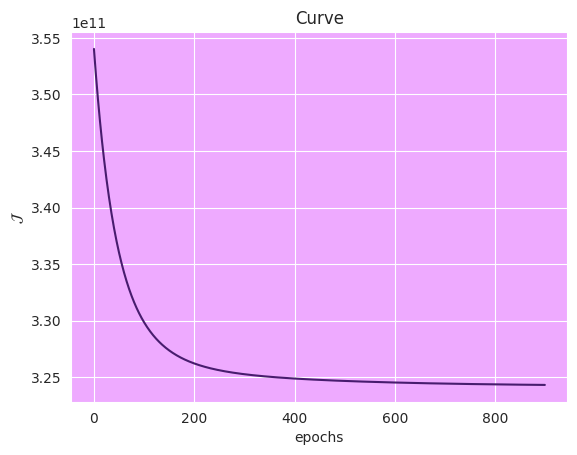

In [116]:
mvlr = MVLinearRegression()
mvlr.fit(X_regres_train, y_train, eta=8e-3, epochs=900, show_curve=True)

In [117]:
y_hat_mvlr_regres_train=mvlr.predict(X_regres_train)

In [118]:
y_hat_mvlr_regres_test=mvlr.predict(X_regres_test)

In [119]:
print("MAE:", mae(y_train, y_hat_mvlr_regres_train))
print("MSE:", mse(y_train, y_hat_mvlr_regres_train))

MAE: 43789553.85179103
MSE: 2107694605876740.0


In [120]:
print("MAE:", mae(y_test, y_hat_mvlr_regres_test))
print("MSE:", mse(y_test, y_hat_mvlr_regres_test))

MAE: 42450822.91316929
MSE: 1925257341457515.8


#Demo

In [121]:
X_demo_latlong = np.array([[-112.520168	, 31.356362]])
X_demo_latlong

array([[-112.520168,   31.356362]])

In [128]:
X_demo = np.array([[5, 2154 , 5 , 6 , 15]])
X_demo

array([[   5, 2154,    5,    6,   15]])

In [129]:
y_hat_knn_demo = KNNclassifiermodel.predict(X_demo_latlong, K=5)
y_hat_knn_demo


array([1.])

In [131]:
combined = np.hstack((y_hat_knn_demo.reshape(1, 1), X_demo))
combined

array([[1.000e+00, 5.000e+00, 2.154e+03, 5.000e+00, 6.000e+00, 1.500e+01]])

In [132]:
y_hat_test_demo = knnr.predict(combined, 8)
y_hat_test_demo

array([0.])

In [133]:
y_hat_train_demo = mvlr.predict(combined)
y_hat_train_demo

array([63435276.71014841])